### Different methods of aggregation from livelihood to admin2
We implemented two methodologies for aggregating FewsNet's livelihood data to admin levels. 
One methodology was to assign one phase per admin2, where this phase equals the one that covers the maximum area in km2. Thereafter this phase is combined with the subnational adm2 population data from HDX's Common Operational Dataset (COD)   
The other methodology is to use Worldpop's raster data, which enables us to assign a percentage of population per IPC phase to each admin2 (instead of having the whole population in one phase per admin2).   
This notebook explores the differences between the two methodologies. Based on this analysis it was chosen to use the Worldpop data as base source, since it captures changes in IPC phases more precisely. Nevertheless, a disadvantage can be that the distribution of population per admin2 by WorldPop can be different than COD, and that the total national population often doesn't correspond. Therefore, we will implement an option to rescale the numbers to COD numbers, whether to use that option will be discussed with the country team. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import os
import sys
path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
sys.path.append(path_mod)
from indicators.food_insecurity.config import Config
from indicators.food_insecurity.ipc_definemetrics import define_trigger_percentage, define_trigger_increase, define_trigger_increase_rel
from indicators.food_insecurity.utils import compute_percentage_columns
from utils_general.plotting import plot_spatial_binary_column

In [3]:
country="ethiopia"
admin_level=1
#suffix of filenames
suffix=""
config=Config()
parameters = config.parameters(country)
country_folder = os.path.join(config.DIR_PATH, config.ANALYSES_DIR, country)
adm1_bound_path= os.path.join(country_folder,config.DATA_DIR,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
fnwp_dir = os.path.join(country_folder, config.DATA_DIR, config.FEWSWORLDPOP_PROCESSED_DIR)
fnwp_path = os.path.join(fnwp_dir,config.FEWSWORLDPOP_PROCESSED_FILENAME.format(country=country,admin_level=admin_level,suffix=suffix))
fnocha_dir = os.path.join(country_folder, config.DATA_DIR, config.FEWSADMPOP_PROCESSED_DIR)
fnocha_path = os.path.join(fnocha_dir,f"{country}_fewsnet_admin{admin_level}.csv")



In [4]:
gdf=gpd.read_file(adm1_bound_path).rename(columns={parameters["shp_adm1c"]:config.ADMIN1_COL})

### WorldPop

In [5]:
df_fadm=pd.read_csv(fnwp_path)
df_fadm["date"]=pd.to_datetime(df_fadm["date"])
df_fadm["year"]=df_fadm["date"].dt.year
df_fadm["month"]=df_fadm["date"].dt.month

In [6]:
df_fadm.tail()

,ADMIN0,ADMIN1,date,CS_1,CS_2,CS_3,CS_4,CS_99,ML1_1,ML1_2,...,ML2_3p,perc_ML2_3p,ML2_4p,perc_ML2_4p,ML2_2m,perc_ML2_2m,perc_inc_ML2_3p,perc_inc_ML1_3p,year,month
511,Ethiopia,Benishangul Gumz,2020-10-01,1.148038e+06,1.172883e+05,0.00000,0.0,NaN,1.148038e+06,1.172883e+05,...,0.000000e+00,0.000000,0.0,0.0,1.265326e+06,100.000000,0.000000,0.000000,2020,10
512,Ethiopia,Afar,2020-10-01,1.613871e+04,1.417134e+06,612370.21875,0.0,NaN,1.613871e+04,1.114601e+06,...,1.761135e+06,86.092025,0.0,0.0,2.845075e+05,13.907975,56.156680,14.789126,2020,10
513,Ethiopia,Addis Ababa,2020-10-01,3.938355e+06,0.000000e+00,0.00000,0.0,NaN,3.938355e+06,0.000000e+00,...,0.000000e+00,0.000000,0.0,0.0,3.938355e+06,100.000000,0.000000,0.000000,2020,10
514,Ethiopia,Tigray,2020-10-01,6.210399e+06,3.347936e+05,0.00000,0.0,NaN,4.480197e+06,2.064996e+06,...,8.561870e+05,13.081159,0.0,0.0,5.689005e+06,86.918841,13.081159,0.000000,2020,10
515,Ethiopia,Amhara,2020-10-01,2.304478e+07,1.651785e+06,0.00000,0.0,NaN,2.078818e+07,3.908391e+06,...,2.575729e+06,10.429500,0.0,0.0,2.212084e+07,89.570500,10.429500,0.000000,2020,10


In [7]:
df_fadm["trigger_ML1_4_20"]=df_fadm.apply(lambda x: define_trigger_percentage(x,"ML1",4,20),axis=1)
df_fadm["trigger_ML1_3_30"]=df_fadm.apply(lambda x: define_trigger_percentage(x,"ML1",3,30),axis=1)
df_fadm["trigger_ML1_3_5i"]=df_fadm.apply(lambda x: define_trigger_increase(x,"ML1",3,5),axis=1)
#currently (Oct 2020) selected trigger
df_fadm_trig=df_fadm.loc[(df_fadm["trigger_ML1_4_20"]==1) | ((df_fadm["trigger_ML1_3_30"]==1) & (df_fadm["trigger_ML1_3_5i"]==1))]
display(df_fadm_trig.groupby(['year', 'month'], as_index=False)[f"ADMIN{admin_level}",'perc_ML1_4','perc_CS_3p','perc_ML1_3p'].agg(lambda x: list(x)))

,year,month,ADMIN1,perc_ML1_4,perc_CS_3p,perc_ML1_3p
0,2009,7,"[Somali, Gambela]","[58.838478590938884, 0.02042319105364591]","[99.92630206112149, 0.35967690558953597]","[99.92630205392872, 60.86321138942488]"
1,2010,1,"[Tigray, Somali, Harari, Dire Dawa, Gambela, A...","[15.498742872540445, 20.9428185393442, 0.0, 0....","[17.812106920283046, 66.21220082737858, 0.0, 0...","[47.74658231203844, 99.94487702875485, 100.0, ..."
2,2010,10,[Somali],[0.0],[3.847626394095229],[29.90268555469125]
3,2011,4,[Somali],[42.04157234227331],[99.70272903008734],[99.72828794624691]
4,2011,7,[Somali],[35.169034032132174],[99.88700508785186],[99.88700510867235]
5,2012,4,[Afar],[0.0],[25.907795306541747],[46.83084649974166]
6,2013,1,"[Somali, Sidama, SNNP]","[0.0, 0.0, 0.0]","[27.985839782976733, 0.0, 8.652726675156972e-05]","[53.664306949241286, 45.78467852807977, 35.326..."
7,2016,2,[Amhara],[2.511534687823407],[24.027335589190763],[29.640725645949203]
8,2017,6,[Somali],[23.77530894791369],[61.220325449332655],[61.35341463827103]
9,2017,10,[Somali],[21.660499771703197],[47.20013319510721],[66.04164880153716]


In [8]:
df_focha=pd.read_csv(fnocha_path)
df_focha=df_focha.rename(columns={parameters["shp_adm1c"]:"ADMIN1"})
df_focha["date"]=pd.to_datetime(df_focha["date"])
df_focha["year"]=df_focha["date"].dt.year
df_focha["month"]=df_focha["date"].dt.month
df_focha=compute_percentage_columns(df_focha,config)

In [9]:
df_focha["trigger_ML1_4_20"]=df_focha.apply(lambda x: define_trigger_percentage(x,"ML1",4,20),axis=1)
df_focha["trigger_ML1_3_30"]=df_focha.apply(lambda x: define_trigger_percentage(x,"ML1",3,30),axis=1)
df_focha["trigger_ML1_3_5i"]=df_focha.apply(lambda x: define_trigger_increase(x,"ML1",3,5),axis=1)
#currently (Oct 2020) selected trigger
df_focha_trig=df_focha.loc[(df_focha["trigger_ML1_4_20"]==1) | ((df_focha["trigger_ML1_3_30"]==1) & (df_focha["trigger_ML1_3_5i"]==1))]
display(df_focha_trig.groupby(['year', 'month'], as_index=False)[f"ADMIN{admin_level}",'perc_ML1_4','perc_CS_3p','perc_ML1_3p'].agg(lambda x: list(x)))

,year,month,ADMIN1,perc_ML1_4,perc_CS_3p,perc_ML1_3p
0,2009,7,"[Gambela, Somali]","[0.0, 62.25048019876748]","[0.0, 100.0]","[82.91970981215955, 100.0]"
1,2010,1,"[Afar, Dire Dawa, Gambela, Harari, Oromia, Som...","[34.30358069903852, 0.0, 82.91970248035976, 0....","[73.90069039391682, 0.0, 82.91970248035976, 0....","[100.0, 100.0, 82.91970248035976, 100.0, 34.21..."
2,2010,10,[Somali],[0.0],[4.3155592447318085],[33.315339657758805]
3,2011,4,[Somali],[43.63107371327632],[100.0],[100.0]
4,2011,7,[Somali],[40.65175737468207],[100.0],[100.0]
5,2012,4,[Afar],[0.0],[25.50364030854231],[59.80724154142381]
6,2013,1,"[SNNP, Sidama, Somali]","[0.0, 0.0, 0.0]","[0.0, 0.0, 28.11168172211739]","[38.98456684147001, 100.0, 59.28994340310864]"
7,2016,2,"[Amhara, Oromia]","[2.340714888464603, 16.56804878138689]","[31.82699327623618, 31.6474039541132]","[38.287677149773096, 41.26491861866744]"
8,2017,6,[Somali],[35.90226426036655],[69.58691042140016],[69.58691042140016]
9,2017,10,[Somali],[25.39301938511138],[49.824775317905676],[69.58691042140016]


In [10]:
df_fadm["threshold_reached"]= np.where((df_fadm["trigger_ML1_4_20"]==1) | ((df_fadm["trigger_ML1_3_30"]==1) & (df_fadm["trigger_ML1_3_5i"]==1)),1,0)
df_fadm=gdf[["ADMIN1","geometry"]].merge(df_fadm,how="right")

df_focha["threshold_reached"]= np.where((df_focha["trigger_ML1_4_20"]==1) | ((df_focha["trigger_ML1_3_30"]==1) & (df_focha["trigger_ML1_3_5i"]==1)),1,0)
df_focha=gdf[["ADMIN1","geometry"]].merge(df_focha,how="right")

In [11]:
len(df_focha_trig)

32

In [12]:
len(df_fadm_trig)

31

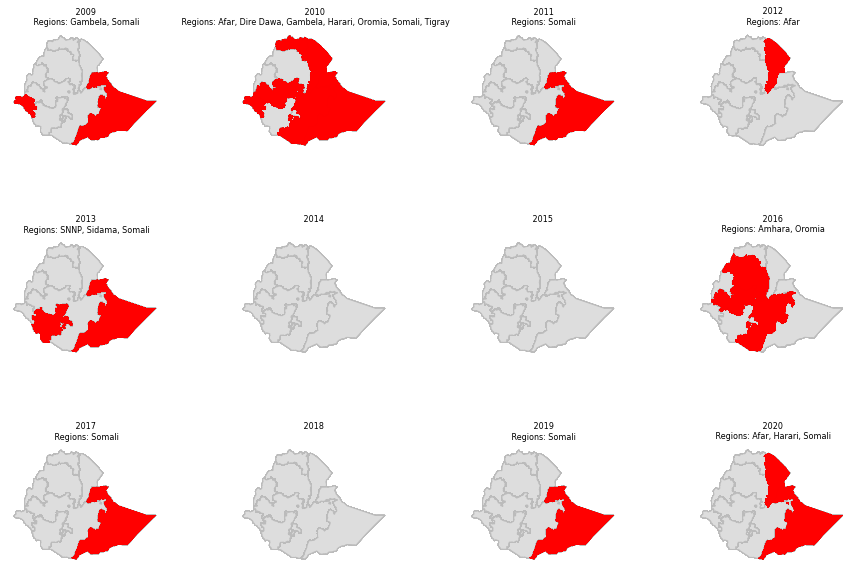

In [13]:
fig_boundbin=plot_boundaries_binary(df_focha,"threshold_reached",subplot_col="year",subplot_str_col="year",region_col="ADMIN1",colp_num=4,only_show_reached=False)

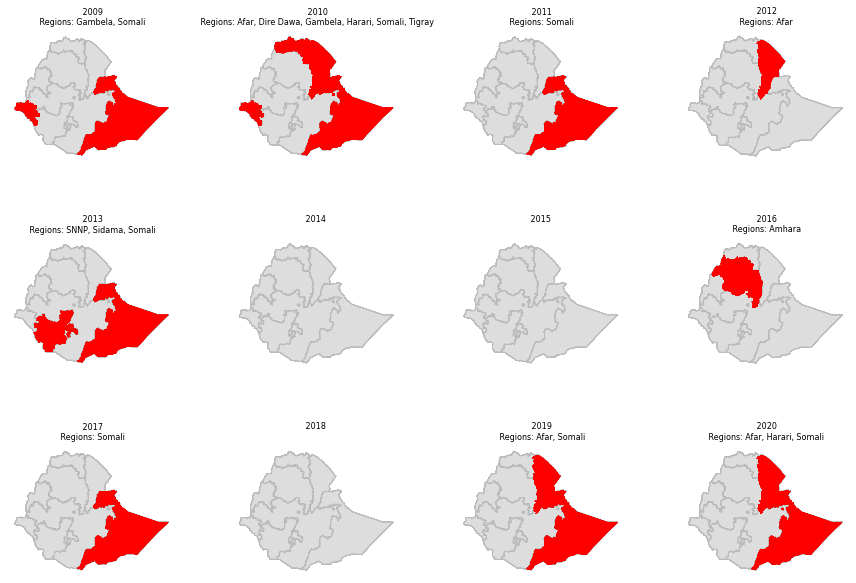

In [14]:
fig_boundbin=plot_boundaries_binary(df_fadm,"threshold_reached",subplot_col="year",subplot_str_col="year",region_col="ADMIN1",colp_num=4,only_show_reached=False)

#### Differences FN OCHA adm pop and Worldpop pop
2010-01 Oromia is triggered with ocha but not with worldpop. This is because the 30% 3+ ML1 is not reached. For worldpop the percentage is 28 whereas for ocha it is 34. Hard to say from images which makes more sense, is a border case.   
2016-02 Oromia is triggered with ocha and not with worldpop. This is because the 5% increase threshold is not reached. For worldpop the percentage is 1.6 and for ocha 9.6. Looking at the images, a relatively small areas changes from ipc3+ to ipc2. However, this area does change one large adm2 from ipc2 to ipc3+. I would argue the worldpop approach is more correct   
2019-10 Afar is triggered with worldpop and not with ocha. This is because the 5% increase threshold is not reached. Looking at the images, there is an increase in area that is projected to be IPC3+ but this doesn't change the major ipc phase coverage of an admin2. Thus would argue the worldpop approach is more correct

#### Digging deeper into differences

In [15]:
df_focha[(df_focha.year==2016)&(df_focha.threshold_reached==1)]

,ADMIN1,geometry,Unnamed: 0,date,Total,adjusted_population,CS_1,CS_2,CS_3,CS_4,...,ML2_4p,perc_ML2_4p,ML2_2m,perc_ML2_2m,perc_inc_ML2_3p,perc_inc_ML1_3p,trigger_ML1_4_20,trigger_ML1_3_30,trigger_ML1_3_5i,threshold_reached
112,Amhara,"POLYGON ((36.52608 13.58428, 36.53155 13.58167...",314,2016-02-01,22808290,22781288,13136053.0,2394636.0,7250599.0,0.0,...,1129226.0,4.956814,10512886.0,46.147022,22.025985,6.460684,0,1,1,1
327,Oromia,"POLYGON ((38.75293 10.37955, 38.76123 10.37559...",319,2016-02-01,39382119,39335495,19449311.0,7437521.0,5931539.0,6517124.0,...,6517124.0,16.568049,21972503.0,55.859226,12.493370,9.617515,0,1,1,1


In [16]:
df_fadm[(df_fadm.year==2016)&(df_fadm.threshold_reached==1)]

,ADMIN1,geometry,ADMIN0,date,CS_1,CS_2,CS_3,CS_4,CS_99,ML1_1,...,ML2_2m,perc_ML2_2m,perc_inc_ML2_3p,perc_inc_ML1_3p,year,month,trigger_ML1_4_20,trigger_ML1_3_30,trigger_ML1_3_5i,threshold_reached
112,Amhara,"POLYGON ((36.52608 13.58428, 36.53155 13.58167...",Ethiopia,2016-02-01,10063250.0,7270070.625,5200414.5,281471.84375,NaN,9204451.0,...,11266410.75,49.381158,26.591507,5.61339,2016,2,0,1,1,1


In [17]:
df_focha[(df_focha.date=="2016-02-01")][["ADMIN1","trigger_ML1_4_20","trigger_ML1_3_30","trigger_ML1_3_5i","perc_CS_3p","perc_ML1_3p","perc_inc_ML1_3p"]]

,ADMIN1,trigger_ML1_4_20,trigger_ML1_3_30,trigger_ML1_3_5i,perc_CS_3p,perc_ML1_3p,perc_inc_ML1_3p
26,Addis Ababa,0,0,0,0.000000,0.000000,0.000000
69,Afar,0,1,0,100.000000,100.000000,0.000000
112,Amhara,0,1,1,31.826993,38.287677,6.460684
155,Benishangul Gumz,0,0,0,0.000000,0.000000,0.000000
198,Dire Dawa,0,1,0,100.000000,100.000000,0.000000
241,Gambela,0,0,0,0.000000,0.000000,0.000000
284,Harari,0,1,0,100.000000,100.000000,0.000000
327,Oromia,0,1,1,31.647404,41.264919,9.617515
370,Sidama,0,0,0,0.000000,0.000000,0.000000
413,SNNP,0,0,0,19.270028,19.270028,0.000000


In [18]:
df_fadm[(df_fadm.date=="2016-02-01")][["ADMIN1","trigger_ML1_4_20","trigger_ML1_3_30","trigger_ML1_3_5i","perc_CS_3p","perc_ML1_3p","perc_inc_ML1_3p"]]

,ADMIN1,trigger_ML1_4_20,trigger_ML1_3_30,trigger_ML1_3_5i,perc_CS_3p,perc_ML1_3p,perc_inc_ML1_3p
26,Addis Ababa,0,0,0,0.000000,0.000000,0.000000e+00
69,Afar,0,1,0,99.743081,99.843140,1.000588e-01
112,Amhara,0,1,1,24.027336,29.640726,5.613390e+00
155,Benishangul Gumz,0,0,0,0.000000,0.016219,1.621858e-02
198,Dire Dawa,0,1,0,100.000000,100.000000,0.000000e+00
241,Gambela,0,0,0,0.363135,0.363135,0.000000e+00
284,Harari,0,1,0,100.000000,100.000000,0.000000e+00
327,Oromia,0,1,0,30.712280,32.292593,1.580313e+00
370,Sidama,0,0,0,11.138070,11.138070,0.000000e+00
413,SNNP,0,0,0,20.407751,20.408362,6.112827e-04


## Differences in population totals and distrubtion of COD and WorldPop and Worldbank

In [19]:
#total numbers. WB is currently used in the df_focha
df_adm2_popocha=pd.read_csv(os.path.join(country_folder,config.DATA_DIR,"Population_OCHA_2020","eth_admpop_adm2_20201028.csv"))
pop_COD=df_adm2_popocha.sum()["Total"]
pop_WP=df_fadm[df_fadm.date=="2020-10-01"].sum()["pop_CS"]
pop_WB=df_focha[df_focha.date=="2020-10-01"].sum()["pop_CS"]
print(f"population assigned of WorldPop: {pop_WP:.0f}")
print(f"population assigned of WorldBank: {pop_WB:.0f} ({(pop_WP-pop_WB):.0f} less than WP)")
print(f"population of COD: {pop_COD:.0f} ({(pop_WP-pop_COD):.0f} less than WP)")

population assigned of WorldPop: 114496435
population assigned of WorldBank: 112078683 (2417752 less than WP)
population of COD: 103726273 (10770162 less than WP)


#### Differences in distribution COD and WorldPop

In [20]:
#compute percentage of pop adm1 per adm2 COD
df_adm2_popocha=df_adm2_popocha[["ADM1_EN","ADM2_EN","Total"]]
df_adm1_popocha=df_adm2_popocha.groupby("ADM1_EN",as_index=False).sum()
#add population of adm1 to each adm2
df_adm2_popocha=df_adm2_popocha.merge(df_adm1_popocha.rename(columns={"Total":"ADM1_Total"}),on="ADM1_EN",how="left")
#compute percentage of pop adm1 per adm2
df_adm2_popocha["perc_ADM1"]=df_adm2_popocha["Total"]/df_adm2_popocha["ADM1_Total"]*100

In [21]:
#compute percentage of pop adm1 per adm2 WorldPop
adm2_popwp_path=os.path.join(fnwp_dir,config.FEWSWORLDPOP_PROCESSED_FILENAME.format(suffix=suffix,country=country,admin_level=2))
df_adm2_popwp=pd.read_csv(adm2_popwp_path)
df_adm2_popwp.date=pd.to_datetime(df_adm2_popwp.date)
# df_adm1_popwp=df_fadm.groupby(["date","ADMIN1"],as_index=False).sum()
df_adm2_popwp=df_adm2_popwp.merge(df_fadm[["date","ADMIN1","pop_CS"]],suffixes=("","_ADM1"),on=["date","ADMIN1"],how="left")
df_adm2_popwp["perc_ADM1"]=df_adm2_popwp["pop_CS"]/df_adm2_popwp["pop_CS_ADM1"]*100

In [22]:
#compute difference two population sources
df_adm2_merge=df_adm2_popocha[["ADM2_EN","perc_ADM1"]].merge(df_adm2_popwp[df_adm2_popwp.date=="2020-10-01"][["ADMIN1","ADMIN2","perc_ADM1"]],left_on="ADM2_EN",right_on="ADMIN2",suffixes=("_COD","_WorldPop"))
df_adm2_merge["perc_diff"]=df_adm2_merge["perc_ADM1_COD"]-df_adm2_merge["perc_ADM1_WorldPop"]

In [23]:
df_adm2_merge.sort_values(by="perc_diff")

,ADM2_EN,perc_ADM1_COD,ADMIN1,ADMIN2,perc_ADM1_WorldPop,perc_diff
89,Dire Dawa rural,36.975839,Dire Dawa,Dire Dawa rural,45.332907,-8.357067
57,Asosa,36.273501,Benishangul Gumz,Asosa,39.592723,-3.319222
46,Fafan,20.074179,Somali,Fafan,23.141755,-3.067576
10,Fanti /Zone 4,14.093454,Afar,Fanti /Zone 4,17.013081,-2.919627
45,Siti,10.338904,Somali,Siti,13.029303,-2.690399
...,...,...,...,...,...,...
6,Mekelle,9.162273,Tigray,Mekelle,6.514978,2.647295
56,Metekel,43.717354,Benishangul Gumz,Metekel,40.830488,2.886865
83,Agnewak,37.502961,Gambela,Agnewak,34.434831,3.068130
7,Awsi /Zone 1,34.303572,Afar,Awsi /Zone 1,29.401888,4.901683


In [24]:
#show adm1 with largest diff
df_adm2_merge[df_adm2_merge["ADMIN1"]=="Dire Dawa"][["ADMIN1","ADMIN2","perc_ADM1_COD","perc_ADM1_WorldPop","perc_diff"]]

,ADMIN1,ADMIN2,perc_ADM1_COD,perc_ADM1_WorldPop,perc_diff
88,Dire Dawa,Dire Dawa urban,63.024161,54.667093,8.357067
89,Dire Dawa,Dire Dawa rural,36.975839,45.332907,-8.357067


In [25]:
#show adm1 with second largest diff
df_adm2_merge[df_adm2_merge["ADMIN1"]=="Afar"][["ADMIN1","ADMIN2","perc_ADM1_COD","perc_ADM1_WorldPop","perc_diff"]]

,ADMIN1,ADMIN2,perc_ADM1_COD,perc_ADM1_WorldPop,perc_diff
7,Afar,Awsi /Zone 1,34.303572,29.401888,4.901683
8,Afar,Kilbati /Zone2,25.503648,27.171735,-1.668087
9,Afar,Gabi /Zone 3,15.327534,13.294252,2.033282
10,Afar,Fanti /Zone 4,14.093454,17.013081,-2.919627
11,Afar,Hari /Zone 5,10.771793,13.119043,-2.347251
